In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from utils.finance_utils import get_financial_data

# Load financial data

In [2]:
df = get_financial_data()
df.head()

/home/grozd/Desktop/Programstvo/Python/SequentialComparison-TVZ/utils/finance_utils.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='max') # Download data
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily Return,Lagged Return,Log Return,SMA 14,ATR 14
Date,,,,,,,,,,
2015-01-02,24.261051,24.729274,23.821675,24.718178,212818400,-0.018494,-0.019019,-0.009558,24.666025,0.555241
2015-01-05,23.577576,24.110152,23.391175,24.030265,257142000,-0.018838,-0.009512,-0.028576,24.610866,0.581078
2015-01-06,23.579800,23.839430,23.218091,23.641933,263188400,-0.002628,-0.028172,0.000094,24.579641,0.542244
2015-01-07,23.910435,24.010292,23.677432,23.788385,160423600,0.005131,0.000094,0.013925,24.595492,0.511177
2015-01-08,24.829130,24.886826,24.121248,24.238859,237458000,0.024352,0.014022,0.037703,24.634801,0.531941


# Converting Pandas DataFrame to NumPy ndarray

In [3]:
X = df.to_numpy()
X.shape

(2678, 10)

# Split and scale

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}')

Train: (2142, 10), Test: (536, 10)


# Create sequences

In [5]:
from utils.torch_utils import create_sequence

X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (2131, 10, 10) (2131, 10)
X_test, y_test: (528, 7, 10) (528, 10)


# Data preparation

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Convert ndarray to torch Tensor
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)
# Put tensors to available device
X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

# Add sequence dimension (Transformer needs both input and output to be sequences) [(batch_size, n_features) -> (batch_size, 1, n_features)]
y_train_seq, y_test_seq = y_train_seq.unsqueeze(1), y_test_seq.unsqueeze(1)

cpu


In [7]:
from utils.torch_utils import StockDataset

batch_size = 64

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model definition

In [8]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.positional_embeddings = nn.Embedding(max_len, d_model)  # Learnable embeddings for each position

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        positions = torch.arange(0, seq_len, dtype=torch.long, device=x.device)  # (seq_len,)
        positional_encoding = self.positional_embeddings(positions)  # (seq_len, d_model)
        positional_encoding = positional_encoding.unsqueeze(0)  # (1, seq_len, d_model)
        return x + positional_encoding


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, output_dim, num_layers=6, nhead=8, dim_feedforward=2048, dropout=0.1, predict_sequence=False):
        super(TransformerModel, self).__init__()

        self.predict_sequence = predict_sequence

        # Project input features to model dimension
        self.input_proj = nn.Sequential(
                            nn.Linear(input_dim, d_model),
                            nn.ReLU(),  # or GELU
                            nn.Linear(d_model, d_model)
                        )

        # Positional encoding (learnable)
        self.pos_enc = PositionalEncoding(d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output projection
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, input_dim)
        """
        B, T, _ = x.size()
        x = self.input_proj(x)
        x = self.pos_enc(x)

        x = self.transformer_encoder(x)

        if self.predict_sequence:
            out = self.fc_out(x)  # Shape: (B, T, output_dim)
        else:
            out = self.fc_out(x[:, -1, :])  # Shape: (B, output_dim)

        return out

In [9]:
n_features = 10
num_layers = 3
num_heads = 8
dropout = 0.1

model = TransformerModel(input_dim=n_features, output_dim=n_features, d_model=128, nhead=num_heads, dropout=dropout, num_layers=num_layers)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Model training

In [10]:
from datetime import datetime

epochs = 100
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    epoch_loss = 0

    for (data, target) in dataloader_train:

        output = model(data)  # output: (B, 1, 10)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

timestamp = datetime.now().strftime("%d-%m-%Y")
torch.save(model.state_dict(), f"models/transformer_m2o_{timestamp}.pth")

/home/grozd/Desktop/Programstvo/Python/SequentialComparison-TVZ/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 10])) that is different to the input size (torch.Size([64, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/grozd/Desktop/Programstvo/Python/SequentialComparison-TVZ/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([19, 1, 10])) that is different to the input size (torch.Size([19, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/100 Avg Loss: 0.6682
Epoch 10/100 Avg Loss: 0.4427
Epoch 20/100 Avg Loss: 0.4028
Epoch 30/100 Avg Loss: 0.4132
Epoch 40/100 Avg Loss: 0.3952
Epoch 50/100 Avg Loss: 0.3909
Epoch 60/100 Avg Loss: 0.3920
Epoch 70/100 Avg Loss: 0.3961
Epoch 80/100 Avg Loss: 0.3972
Epoch 90/100 Avg Loss: 0.4034
Epoch 100/100 Avg Loss: 0.4138


# Model evaluation

In [11]:
model.eval()

with torch.no_grad():

    preds = model(X_test_seq)

    val_loss = criterion(preds, y_test_seq)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 0.7071371674537659


/home/grozd/Desktop/Programstvo/Python/SequentialComparison-TVZ/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([528, 1, 10])) that is different to the input size (torch.Size([528, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Plot train results

(2131, 10)


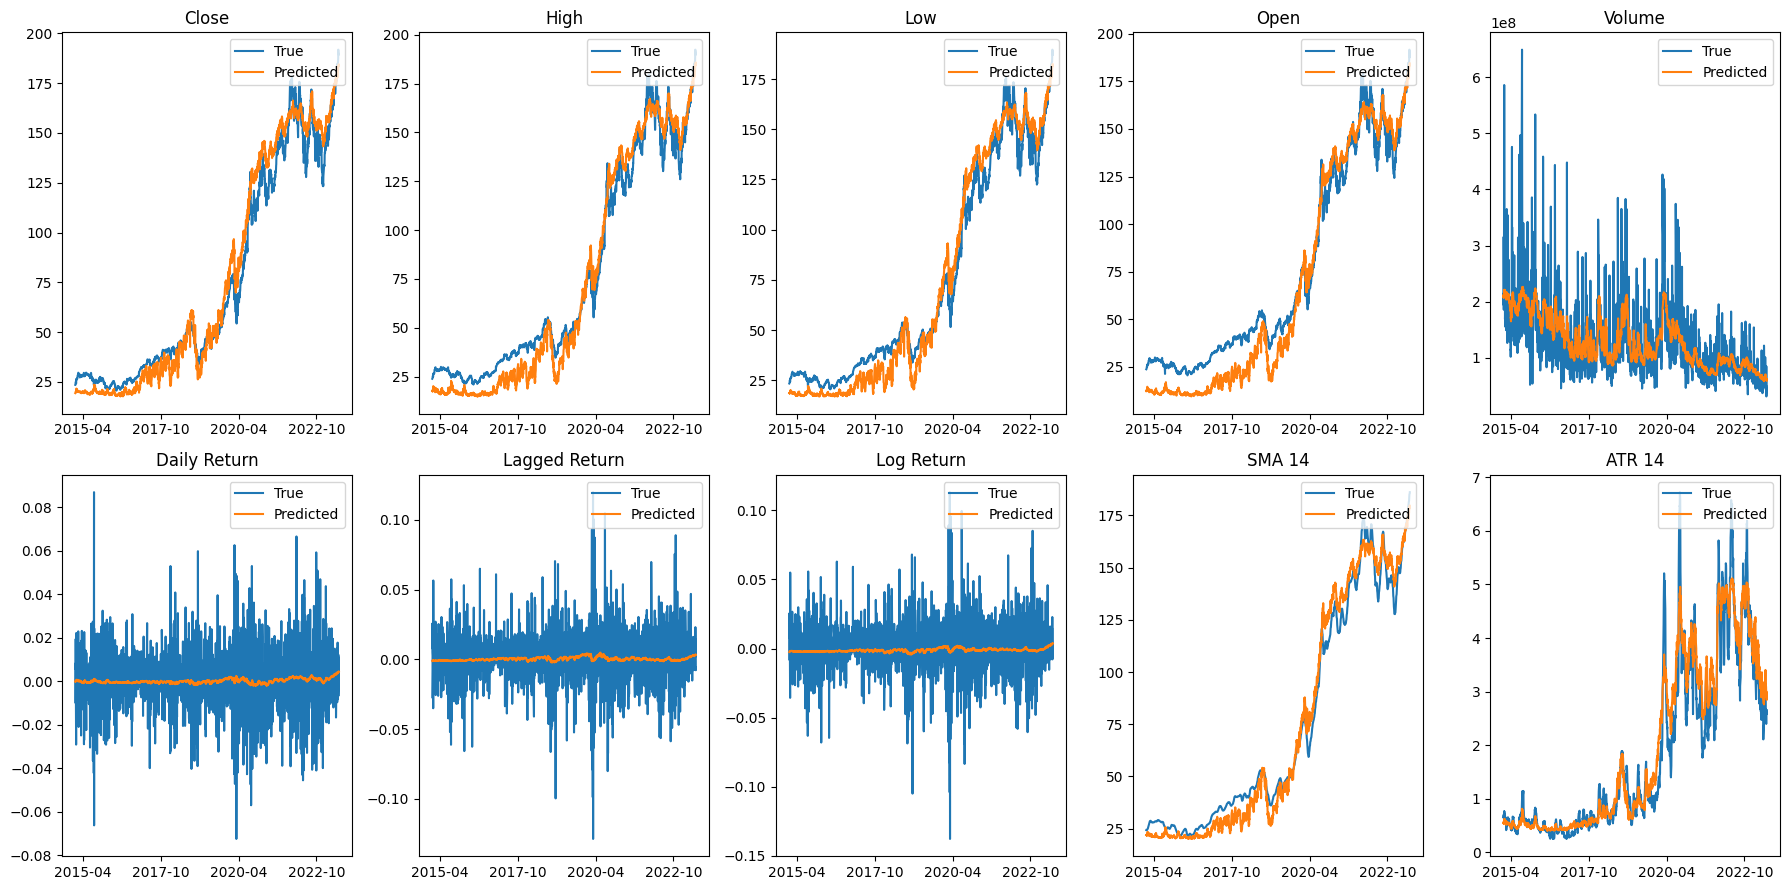

In [12]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

y_true = scaler.inverse_transform(y_train_seq.squeeze(1).cpu().detach().numpy())
y_pred = model(X_train_seq).squeeze(1).cpu().detach().numpy()
print(f'{y_pred.shape}')
y_pred = scaler.inverse_transform(y_pred)

train_dates = df.index[:len(X_train_seq)]

for idx, c in enumerate(df.columns):
    axes[idx].plot(train_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(train_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Plotting test results

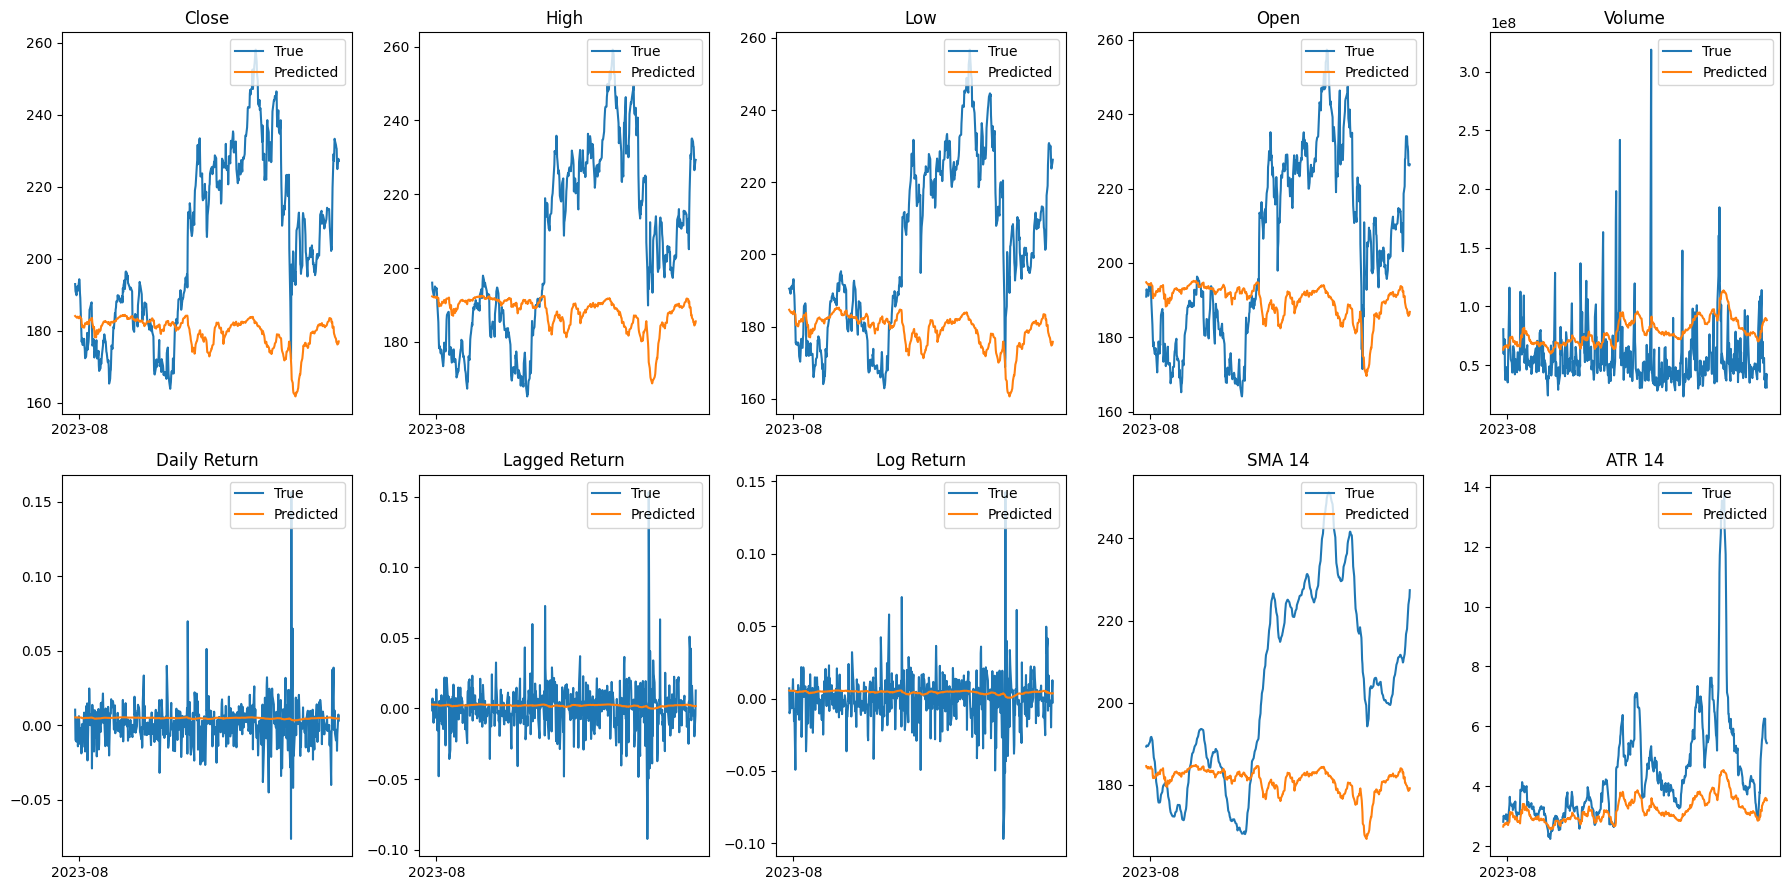

In [16]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

y_true = scaler.inverse_transform(y_test_seq.squeeze(1).cpu().detach().numpy())
y_pred = model(X_test_seq).squeeze(1).cpu().detach().numpy()
y_pred = scaler.inverse_transform(y_pred)

test_dates = df.index[-len(y_true):]

for idx, c in enumerate(df.columns):
    axes[idx].plot(test_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(test_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Create sequences

- many-to-many

In [17]:
X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10, target_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7, target_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (2122, 10, 10) (2122, 10, 10)
X_test, y_test: (522, 7, 10) (522, 7, 10)


In [18]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

In [19]:
batch_size = 128

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [20]:
n_features = 10
num_layers = 3
num_heads = 8
dropout = 0.1

model = TransformerModel(input_dim=n_features, 
                         output_dim=n_features, 
                         d_model=128,
                         nhead=num_heads, 
                         dropout=dropout,
                         num_layers=num_layers, 
                         predict_sequence=True)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [21]:
epochs = 100
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    epoch_loss = 0

    for (data, target) in dataloader_train:

        output = model(data)  # shape: (B, 10, 10)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

timestamp = datetime.now().strftime("%d-%m-%Y")
torch.save(model.state_dict(), f"models/transformer_m2m_{timestamp}.pth")

Epoch 0/100 Avg Loss: 1.5301
Epoch 10/100 Avg Loss: 0.4215
Epoch 20/100 Avg Loss: 0.4342
Epoch 30/100 Avg Loss: 0.4384
Epoch 40/100 Avg Loss: 0.3900
Epoch 50/100 Avg Loss: 0.4101
Epoch 60/100 Avg Loss: 0.3739
Epoch 70/100 Avg Loss: 0.3840
Epoch 80/100 Avg Loss: 0.4269
Epoch 90/100 Avg Loss: 0.3677
Epoch 100/100 Avg Loss: 0.3819


In [22]:
model.eval()

with torch.no_grad():
    
    preds = model(X_test_seq.to(device))

    val_loss = criterion(preds, y_test_seq)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 0.6387110352516174


# Plot train results (one random sequence)

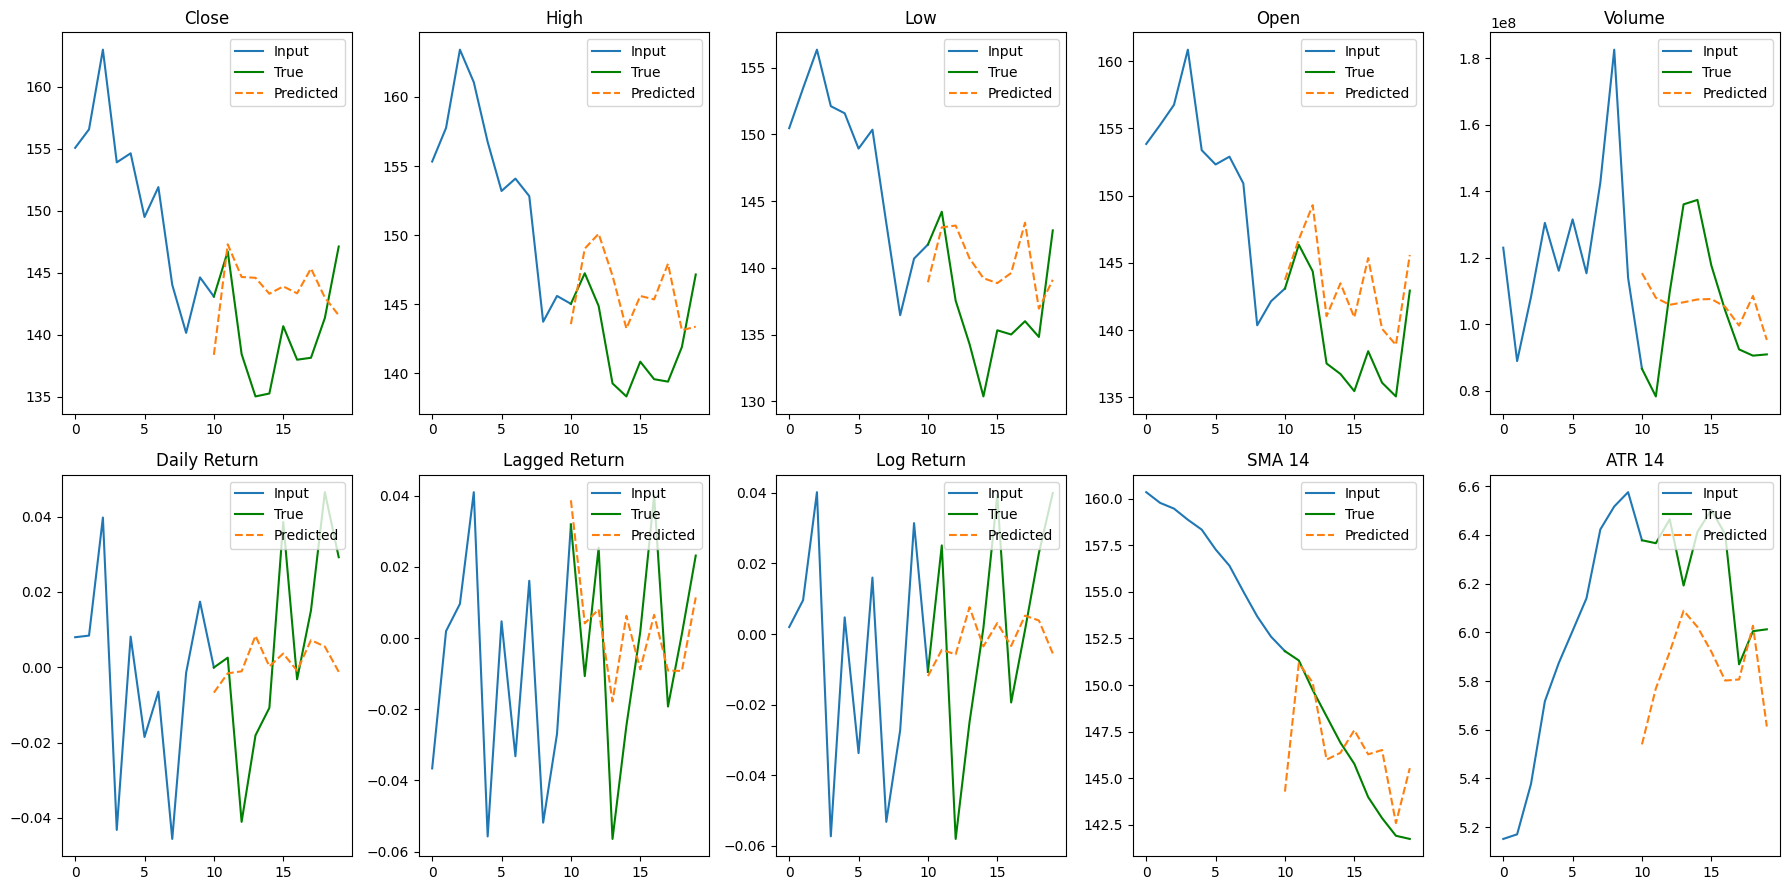

In [32]:
rand_idx = np.random.randint(0, len(X_train_seq))

x = X_train_seq[rand_idx].cpu().detach().numpy()

y_true = y_train_seq[rand_idx].cpu().detach().numpy()
y_pred = model(X_train_seq)[rand_idx].cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot test results (one random sequence)

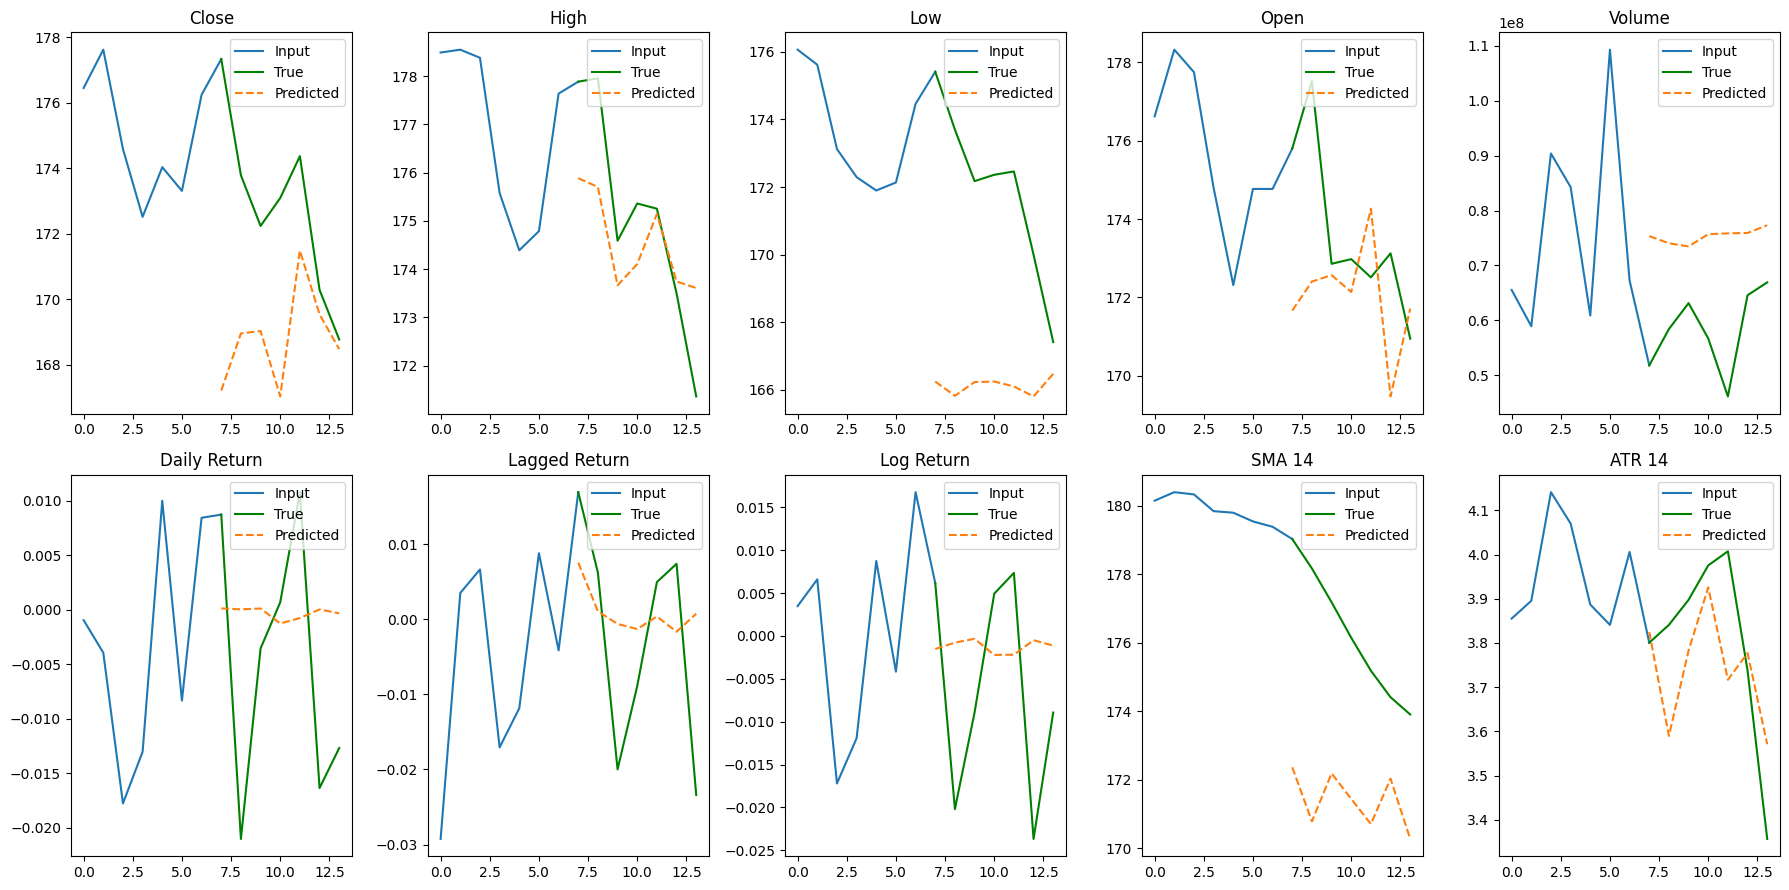

In [30]:
rand_idx = np.random.randint(0, len(X_test_seq))

x = X_test_seq[rand_idx].cpu().detach().numpy()

y_true = y_test_seq[rand_idx].cpu().detach().numpy()
y_pred = model(X_test_seq)[rand_idx].cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()